In [53]:
from network_evaluation_tools import gene_conversion_tools as gct
import re
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [17]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0

## Load ConsensusPathDB Raw Data
#### Source: http://cpdb.molgen.mpg.de/download/ConsensusPathDB_human_PPI.gz
Downloaded: November 16, 2021  
Last Updated: June 19, 2021
We only downloaded the protein interaction part of this database.  
#### From the website:  
"The protein interaction part of the integrated network is available for download. Due to several licensing issues, we are not allowed to release the complete integrated network (including signaling, metabolism and gene regulation).
Rows with one protein only describe self-interactions, and rows with more than two proteins describe complex interactions. In cases when proteins are annotated only with genomic identifiers but no protein identifiers in the according source databases, and if the genomic identifiers map to more than one UniProt entry, the according UniProt entry names are concatenated (e.g. RL40_HUMAN.RS27A_HUMAN.UBIQ_HUMAN) as it is unclear which of the gene products interact."  
#### Note about processing gene names:
The gene names here are all listed as UniProtKB-IDs, however, MyGene.Info does not map these ID names. Therefore, we will use the UniProtKB mapping table (https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz) to convert from the UniProtKB-IDs to the gene name. We will only be using the human mappings. UniProtKB-IDs with Gene Names mapped to the same UniProt Accession number in the first column will be mapped together. Updated version of mapping downloaded November 18, 2021
#### Note about 'interaction confidence'
This column could potentially be used to filter interactions, but since we include the co-complex interactions in the list of interactors and these do not have an interaction confidence, we do not consider this scoring for a filtering of ConsensusPathDB

In [18]:
CPDB_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/ConsensusPathDB_human_PPI_v35.tsv',sep='\t',skiprows=1)
print(CPDB_Raw_v2.shape[0], 'raw interactions in ConsensusPathDB')

554471 raw interactions in ConsensusPathDB


In [19]:
# Get all interaction from CPDB
CPDB_Raw_Interactions_v2 = list(CPDB_Raw_v2['interaction_participants'])

In [20]:
# Remove self-edges from CPDB interactions
CPDB_Raw_Interactions_filt_v2 = []
for interaction in CPDB_Raw_Interactions_v2:
    interaction_split = re.split(',|\.', interaction)
    if len(interaction_split) > 1:
        CPDB_Raw_Interactions_filt_v2.append(interaction_split)

In [21]:
# Extract Binary interactions from lists of interactors (multi-protein complex interactions form cliques)
CPDB_binary_interactions_v2 = [list(itertools.combinations(gene_list, 2)) for gene_list in CPDB_Raw_Interactions_filt_v2]
full_CPDB_interaction_list_v2 = list(itertools.chain(*CPDB_binary_interactions_v2))
print('Binary, non-self interactions in ConsensusPathDB v35:', len(full_CPDB_interaction_list_v2))

Binary, non-self interactions in ConsensusPathDB v35: 10625935


## Processing UniProtKB ID mapping files

In [22]:
# Load UniProt idmapping File
UniProt_ID_map_v2 = pd.read_csv(wd+ 'Network_Data_Raw/HUMAN_9606_idmapping.dat.gz', sep='\t', header=None)

In [23]:
# Construct UniProtKB to UniProt Accession
UniProt_ID_map_filt_v2 = UniProt_ID_map_v2[(UniProt_ID_map_v2[1]=='UniProtKB-ID')]
UniProt_ID_map_filt_v2 = UniProt_ID_map_filt_v2.set_index(2)
UniProtKB_ID_map_v2 = UniProt_ID_map_filt_v2[0].to_dict()

In [24]:
# Convert CPDB interaction list to UniProt Accessions (if any interactions do not convert, do not keep the interaction)
CPDB_UniProtID_edgelist_v2 = []
for edge in full_CPDB_interaction_list_v2:
    if (edge[0] in UniProtKB_ID_map_v2) & (edge[1] in UniProtKB_ID_map_v2):
        converted_edge = sorted([UniProtKB_ID_map_v2[edge[0]], UniProtKB_ID_map_v2[edge[1]]])
        CPDB_UniProtID_edgelist_v2.append(converted_edge)
print(len(CPDB_UniProtID_edgelist_v2), 'interactions converted to UniProt Accession IDs')

10592662 interactions converted to UniProt Accession IDs


In [25]:
CPDB_UniProtID_edgelist_v2 = pd.DataFrame(CPDB_UniProtID_edgelist_v2, columns=["n1", "n2"])

In [26]:
# Remove self-edges and duplicate edges after conversion
CPDB_UniProtID_edgelist_filt_v2 = gct.filter_converted_edgelist(CPDB_UniProtID_edgelist_v2, node_cols=["n1", "n2"])

10592662 input edges
116 self-edges removed
0 edges with un-mapped genes removed
5198949 duplicate edges removed
Edge list filtered: 3.65 seconds
5393597 Edges remaining


In [27]:
CPDB_Converted_Genes_v2 = list(set(list(CPDB_UniProtID_edgelist_v2.n1.values) + list(CPDB_UniProtID_edgelist_v2.n2.values)))

## Convert Uniprot Accession IDs to HUGO Gene Symbol / Entrez ID

In [28]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(CPDB_Converted_Genes_v2)

20683 Valid Query Genes
0 Invalid Query Genes


In [29]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"
# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"
# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)
print(len(match_list_v2), 'Matched query results')

100%|██████████| 21/21 [00:14<00:00,  1.45it/s]

21054 Matched query results
Batch query complete: 14.5 seconds
21054 Matched query results


In [30]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_genes_v2)

Queries without full matching results found: 1727

262 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 11.38 seconds


In [31]:
# Convert UniProt Accession ID CPDB edgelist to gene symbols
CPDB_edgelist_symbol_v2 = gct.convert_edgelist(CPDB_UniProtID_edgelist_filt_v2, query_to_symbol_v2)
CPDB_edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(CPDB_edgelist_symbol_v2)

5393597 input edges
228 self-edges removed
120217 edges with un-mapped genes removed
55257 duplicate edges removed
Edge list filtered: 1.86 seconds
5217895 Edges remaining


In [32]:
# Save CPDB as gene symbol network
gct.write_edgelist(CPDB_edgelist_symbol_filt_v2, wd+'/Processed_Data/Network_SIFs_Symbol/ConsensusPathDB_Symbol_v35.sif')

Edge list saved: 4.63 seconds


# Version 1 (original)

## Load ConsensusPathDB Raw Data
#### Source: http://cpdb.molgen.mpg.de/download/ConsensusPathDB_human_PPI.gz
Downloaded: June 15, 2017  
Last Updated: January 11, 2017  
We only downloaded the protein interaction part of this database.  
#### From the website:  
"The protein interaction part of the integrated network is available for download. Due to several licensing issues, we are not allowed to release the complete integrated network (including signaling, metabolism and gene regulation).
Rows with one protein only describe self-interactions, and rows with more than two proteins describe complex interactions. In cases when proteins are annotated only with genomic identifiers but no protein identifiers in the according source databases, and if the genomic identifiers map to more than one UniProt entry, the according UniProt entry names are concatenated (e.g. RL40_HUMAN.RS27A_HUMAN.UBIQ_HUMAN) as it is unclear which of the gene products interact."  
#### Note about processing gene names:
The gene names here are all listed as UniProtKB-IDs, however, MyGene.Info does not map these ID names. Therefore, we will use the UniProtKB mapping table (ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz) to convert from the UniProtKB-IDs to the gene name. We will only be using the human mappings. UniProtKB-IDs with Gene Names mapped to the same UniProt Accession number in the first column will be mapped together. 
#### Note about 'interaction confidence'
This column could potentially be used to filter interactions, but since we include the co-complex interactions in the list of interactors and these do not have an interaction confidence, we do not consider this scoring for a filtering of ConsensusPathDB
#### Note about 2021 update
There are slight differences when re-running this processing pipeline (despite identical input data), most likely due to changes in gene/protein identifiers in the mygene.info database

In [33]:
CPDB_Raw = pd.read_csv(wd+'Network_Data_Raw/ConsensusPathDB_human_PPI_v32',sep='\t',skiprows=1)
print(CPDB_Raw.shape[0], 'raw interactions in ConsensusPathDB')

291415 raw interactions in ConsensusPathDB


In [34]:
# Get all interaction from CPDB
CPDB_Raw_Interactions = list(CPDB_Raw['interaction_participants'])

In [35]:
# Remove self-edges from CPDB interactions
CPDB_Raw_Interactions_filt = []
for interaction in CPDB_Raw_Interactions:
    interaction_split = re.split(',|\.', interaction)
    if len(interaction_split) > 1:
        CPDB_Raw_Interactions_filt.append(interaction_split)

In [36]:
# Extract Binary interactions from lists of interactors (multi-protein complex interactions form cliques)
CPDB_binary_interactions = [list(itertools.combinations(gene_list, 2)) for gene_list in CPDB_Raw_Interactions_filt]
full_CPDB_interaction_list = list(itertools.chain(*CPDB_binary_interactions))
print('Binary, non-self interactions in ConsensusPathDB v32:', len(full_CPDB_interaction_list))

Binary, non-self interactions in ConsensusPathDB v32: 2523991


## Processing UniProtKB ID mapping files

In [37]:
# Load UniProt idmapping File
UniProt_ID_map = pd.read_csv(wd+ 'Network_Data_Raw/HUMAN_9606_idmapping_original.dat', sep='\t', header=None)

In [38]:
# Construct UniProtKB to UniProt Accession
UniProt_ID_map_filt = UniProt_ID_map[(UniProt_ID_map[1]=='UniProtKB-ID')]
UniProt_ID_map_filt = UniProt_ID_map_filt.set_index(2)
UniProtKB_ID_map = UniProt_ID_map_filt[0].to_dict()

In [39]:
# Convert CPDB interaction list to UniProt Accessions (if any interactions do not convert, do not keep the interaction)
CPDB_UniProtID_edgelist = []
for edge in full_CPDB_interaction_list:
    if (edge[0] in UniProtKB_ID_map) & (edge[1] in UniProtKB_ID_map):
        converted_edge = sorted([UniProtKB_ID_map[edge[0]], UniProtKB_ID_map[edge[1]]])
        CPDB_UniProtID_edgelist.append(converted_edge)
print(len(CPDB_UniProtID_edgelist), 'interactions converted to UniProt Accession IDs')

2501019 interactions converted to UniProt Accession IDs


In [40]:
CPDB_UniProtID_edgelist = pd.DataFrame(CPDB_UniProtID_edgelist, columns=["n1", "n2"])

In [41]:
# Remove self-edges and duplicate edges after conversion
CPDB_UniProtID_edgelist_filt = gct.filter_converted_edgelist(CPDB_UniProtID_edgelist, node_cols=["n1", "n2"])

2501019 input edges
26 self-edges removed
0 edges with un-mapped genes removed
788438 duplicate edges removed
Edge list filtered: 0.87 seconds
1712555 Edges remaining


In [42]:
CPDB_Converted_Genes = list(set(list(CPDB_UniProtID_edgelist.n1.values) + list(CPDB_UniProtID_edgelist.n2.values)))

## Convert Uniprot Accession IDs to HUGO Gene Symbol / Entrez ID

In [43]:
query_string, valid_genes, invalid_genes = gct.query_constructor(CPDB_Converted_Genes)

18642 Valid Query Genes
0 Invalid Query Genes


In [44]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"
# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"
# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]

18927 Matched query results
Batch query complete: 13.91 seconds
18927 Matched query results


In [45]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 1432

203 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 9.15 seconds


In [47]:
# Convert UniProt Accession ID CPDB edgelist to gene symbols
CPDB_edgelist_symbol = gct.convert_edgelist(CPDB_UniProtID_edgelist_filt, query_to_symbol)
CPDB_edgelist_symbol_filt = gct.filter_converted_edgelist(CPDB_edgelist_symbol)

1712555 input edges
147 self-edges removed
42286 edges with un-mapped genes removed
16367 duplicate edges removed
Edge list filtered: 0.59 seconds
1653755 Edges remaining


In [48]:
# Save CPDB as gene symbol network
gct.write_edgelist(CPDB_edgelist_symbol_filt, wd+'Processed_Data/Network_SIFs_Symbol/ConsensusPathDB_Symbol_v32.sif')

Edge list saved: 1.46 seconds


# Changes

In [49]:
stats = pd.DataFrame({"v1":[291415, 2523991, 2501019, 1712555, 1653755],
                     "v2":[554471, 10625935, 10592662, 5393597, 5217895]},
                     index=["input", "binary", "uniprot", "filtered1", "filtered2"])

In [54]:
nodes_v1 = set(CPDB_edgelist_symbol_filt["symbol_n1"].values).union(set(CPDB_edgelist_symbol_filt["symbol_n2"].values))
nodes_v2 = set(CPDB_edgelist_symbol_filt_v2["symbol_n1"].values).union(set(CPDB_edgelist_symbol_filt_v2["symbol_n2"].values))

Text(0, 0.5, 'Number of nodes')

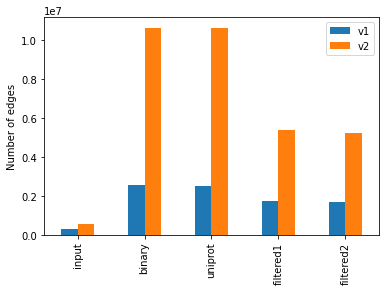

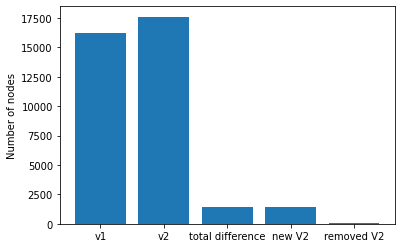

In [56]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")